<a href="https://colab.research.google.com/github/felipequecole/rok-inventory-calc/blob/main/rok_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rise of Kingdoms - Inventory scanner and calculator

### Setup

We need to install pytesseract and import the relevant libs

In [3]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install Pillow
! pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,859 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123598 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [211]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow import data as tf_data
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pytesseract
from scipy import stats

In [214]:
# Constants
DRIVE_PATH = '/content/drive/MyDrive/__rok/'
INPUT_PATH = DRIVE_PATH + 'labeled/'
DEBUG = False
img_width, img_height = 90, 90
image_size = (img_width, img_height)

### Train model

In [ ]:
# Load datasets

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    INPUT_PATH+'___train',
    seed=1337,
    image_size=(img_width, img_height),
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    INPUT_PATH+'___validation',
    seed=1337,
    image_size=(img_width, img_height),
)

label_map = (dataset.class_names)
classes = len(label_map)

In [ ]:
data_augmentation_layers = [
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.3),
    layers.RandomCrop(img_width, img_height),
    layers.RandomBrightness(0.3),
    layers.RandomFlip('horizontal'),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
# Apply `data_augmentation` to the training images.
dataset = dataset.map(
    lambda img, label: (data_augmentation(img), tf.one_hot(label, depth=classes)),
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Apply one hot conversion to validation.
validation_dataset = validation_dataset.map(
    lambda img, label: (img, tf.one_hot(label, depth=classes)), # Convert labels to one-hot encoding
    num_parallel_calls=tf_data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
dataset = dataset.prefetch(tf_data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf_data.AUTOTUNE)

In [ ]:
def make_model_simpler(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64, activation=None)(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.55)(x)

    if num_classes == 2:
      units = 1
    else:
      units = num_classes

    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)

model = make_model_simpler(input_shape=image_size + (3,), num_classes=classes)
keras.utils.plot_model(model, show_shapes=True)
model.summary()

In [ ]:
epochs = 7

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

print(type(dataset))

model.compile(
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
              optimizer='adam'
             )

model.fit(
    dataset,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_dataset,
)

from datetime import date

today = date.today()

d1 = today.strftime("%Y%m%d")

model.save(DRIVE_PATH+f'model_{d1}.keras')

### Load Model

In [6]:
model = keras.models.load_model(DRIVE_PATH+'model_20240803.keras')
label_map = ['F', 'GEM', 'G', 'S', 'W']
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 90, 90, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 90, 90, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 45, 45, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 995,729 (3.80 MB)

 Trainable params: 331,909 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 663,820 (2.53 MB)

In [7]:
def prepare_image(img):
  # convert the color from BGR to RGB then convert to keras acceptable input format
  cvt_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # resize the array (image) then PIL image
  im_resized = cv2.resize(cvt_image, image_size)
  image_array_expanded = np.expand_dims(im_resized, axis = 0)
  return image_array_expanded

In [8]:
def get_resource_type(model, img):
  img_array = prepare_image(img)
  prediction = model.predict(img_array)
  return label_map[np.argmax(prediction)]

### Image processing from screenshot

In [9]:
# Reject outliers for any array (used to reject outlier areas/contours)
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]


def is_rectangle(contour):
  polygon = cv2.approxPolyDP(contour, 0.1 * cv2.arcLength(contour, True), True)
  return len(polygon) == 4

# Calculate the contours (we only care for external at this point)
def get_contours(input_image):
  img = input_image.copy()
  edges = cv2.Canny(img, 0, 100)
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

# Filter contours based on their area, removing outliers
def filter_contours(contours, upper_area_threshold=10, lower_area_threshold=10):

  desired_height = 95
  desired_length = 95

  min_area = (desired_height - lower_area_threshold) * (desired_height - lower_area_threshold)
  max_area = (desired_height + upper_area_threshold) * (desired_height + upper_area_threshold)

  area_hash = dict()
  cnt_hash = dict()
  areas = list()
  idx = 0
  for cnt in contours:
    area = cv2.contourArea(cnt)
    is_rect = is_rectangle(cnt)
    if (is_rect
        and area
        and area != 0.0
        and area >= min_area
        and area <= max_area
        ):
      cnt_hash[idx] = cnt
      area_hash[idx] = area
      areas.append(area)
      idx += 1
    elif (is_rect and area and area != 0.0 and DEBUG):
      print(f'Rejecting {area} because it does not match expected format')

  print(areas)
  areas = np.array(areas)
  average_area = np.mean(areas)
  median_area = np.median(areas)
  print(f'Total areas: {len(areas)} - min: {min_area} max: {max_area} average: {average_area} median: {median_area}')
  return [cnt_hash[k] for k in cnt_hash]

# Apply dilate and erode multiple times (makes it easier to find contours)
def get_opened(image, kernel, dilate_erode_iters = (9, 9)):
  img = image.copy()
  img = cv2.dilate(img, np.ones((3, 3), np.uint8), iterations=dilate_erode_iters[0])
  img = cv2.erode(img, np.ones((3, 3), np.uint8), iterations=dilate_erode_iters[1])
  return img

# Get multiple sub images based on the rectangle area of the contours
def crop_on_contour(img, contours):
  sub_images = list()
  for c in contours:
    x,y,w,h = cv2.boundingRect(c)
    sub_images.append(img[y:y+h, x:x+w])
  return sub_images

In [10]:
def get_inventory_items(img):
  """
  Receives the original screenshot (as cv2 image) processes and
  gets individual rss tokens
  """
  img_copy = img.copy()
  # Gray scale
  gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

  # Apply threshold
  thres = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)[1]

  # kernel = np.ones((3, 3), np.uint8)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))

  # Apply close
  preproc_image = cv2.morphologyEx(thres, cv2.MORPH_CLOSE, kernel, iterations=4)

  # Get all contours
  contours = get_contours(preproc_image)
  # Filter those matching criteria
  contours = filter_contours(contours,  upper_area_threshold=30, lower_area_threshold=10)
  # Get subimages
  sub_images = crop_on_contour(img_copy, contours)
  # Resize and return
  return [cv2.resize(si, image_size) for si in sub_images]

### OCR - Detecting numbers in the item images

In [191]:
# Masking utils

def filter_color(img, color, color_threshold):
  lower_bound = np.array([max(0, color[0] - color_threshold), max(0, color[1] - color_threshold), max(0, color[2] - color_threshold)])
  upper_bound = np.array([min(255, color[0] + color_threshold), min(255, color[1] + color_threshold), min(255, color[2] + color_threshold)])
  return cv2.inRange(img, lower_bound, upper_bound)


def filter_white_num(img, color_threshold=1):
  white = (255, 255, 255)
  return filter_color(img, white, color_threshold)


def filter_black_num(img, color_threshold=1):
  black = (10, 10, 10)
  return filter_color(img, black, color_threshold)

def invert_image(img):
  return cv2.bitwise_not(img)

def threshold_image(img):
  _, thres = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
  return thres

def enhance_image(img, bright=1.5, contrast=1.5):

  alpha = contrast # Contrast control (1.0-3.0)
  beta = bright # Brightness control (0-100)
  adjusted = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

  return adjusted

In [205]:
def prepare_and_run_ocr(img, white_step=10, black_step=25, iterations=10):
  # Converts to gray scale
  img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  item_count_votes = []
  available_count_votes = []
  height, width, channels = img.shape
  top_count = img[0:int(height/3), 0:width]
  bottom_count = img[-int(height/3):, 0:width]

  if (DEBUG):
      print(f'Cropped')
      print('Top:')
      cv2_imshow(top_count)
      print('Bottom')
      cv2_imshow(bottom_count)

  for i in range(iterations):

    black_filtered = enhance_image(top_count, bright=1.0 + (i * 0.25), contrast=1.5 + (i * 0.5))
    white_filtered = enhance_image(bottom_count, bright=1.0 + (i * 0.25), contrast=1.5 + (i * 0.5))

    if (DEBUG):
      print(f'After enhancing')
      print('Top')
      cv2_imshow(black_filtered)
      print('Bottom:')
      cv2_imshow(white_filtered)

    black_filtered = filter_black_num(top_count, i * black_step)
    white_filtered = filter_white_num(bottom_count, i * white_step)

    if (DEBUG):
      print(f'After masking')
      print('Top')
      cv2_imshow(black_filtered)
      print('Bottom:')
      cv2_imshow(white_filtered)

    # # Invert because teseract can handle better
    white_filtered = invert_image(white_filtered)
    black_filtered = invert_image(black_filtered)

    if (DEBUG):
      print(f'After inverting')
      print('Top')
      cv2_imshow(black_filtered)
      print('Bottom:')
      cv2_imshow(white_filtered)

    # Item count (eg, if the item is 50k, 150k, etc) is in black
    try:
      item_count = int(pytesseract.image_to_string(black_filtered, config=r'--oem 3 --psm 6 -c tessedit_char_whitelist="1234567890"'))
      item_count_votes.append(item_count)
      if (DEBUG):
        print(f'Item count: {item_count} on iteration {i}')
    except:
      if (DEBUG):
        print(f'Unable to determine item count (iteration: {i} of {iterations})')

    try:
      # Available count (how many of that you have) is in white
      available_count = int(pytesseract.image_to_string(white_filtered, config=r'--oem 3 --psm 6 -c tessedit_char_whitelist="1234567890"'))
      available_count_votes.append(available_count)
      if (DEBUG):
        print(f'Available count: {available_count} on iteration {i}')
    except:
      if (DEBUG):
        print(f'Unable to determine available count (iteration: {i} of {iterations})')
  mode_item_count = stats.mode(item_count_votes)
  mode_available_count = stats.mode(available_count_votes)
  if (DEBUG):
    print(f'Item count votes: {item_count_votes}')
    print(f'Available count votes: {available_count_votes}')
    print(f'Mode item count: {mode_item_count}')
    print(f'Mode available count: {mode_available_count}')

  item_count = mode_item_count.mode
  available_count = mode_available_count.mode
  # Item count is the hardest to detect, so we go HAM
  # If we do not have a clear agreement
  if (mode_item_count.count == 1):
    # Get the median of the votes
    item_count = np.median(item_count_votes)
    if (DEBUG):
      print(f'No agreement on OCR, returning item count: {item_count}')
  if (mode_available_count.count == 1):
    available_count = np.median(available_count_votes)
  return item_count, available_count


def get_item_count_and_available_count(img, item_type, max_retries=5):
  # Possible values for resource token

  # Food and Wood
  possible = np.array([1_000, 10_000, 50_000, 150_000, 500_000, 1_500_000, 5_000_000])

  # Stone
  if (item_type == 'S'):
    possible = np.array([750, 7_500, 37_500, 112_500, 375_000, 1_125_000, 3_750_000])
  # Gold
  elif (item_type == 'G'):
    possible = np.array([500, 3_000, 15_000, 50_000, 200_000, 600_000, 2_000_000])
  elif (item_type == 'GEM'):
    possible = np.array([x for x in range(5, 10_000, 5)])

  item_count, available_count = prepare_and_run_ocr(img)

  item_count = possible.flat[np.abs(possible - item_count).argmin()]
  print(f'Found {available_count} items of {item_type} * {item_count:,}')
  return possible.flat[np.abs(possible - item_count).argmin()], available_count

### Connecting everything

In [207]:
def get_total_item_from_screenshot(inventory_screenshot):
  inventory_items = get_inventory_items(inventory_screenshot)
  total_by_type = dict()
  for item in inventory_items:
    print("##########################")
    try:
      cv2_imshow(item)
      item_type = get_resource_type(model, item)
      print(item_type)
      item_count, available_count = get_item_count_and_available_count(item, item_type, DEBUG)
      if (item_type not in total_by_type):
        total_by_type[item_type] = item_count * available_count
      else:
        total_by_type[item_type] += item_count * available_count
    except:
      print('Error')
      raise
    # break
  return total_by_type



[9425.5, 9425.0, 9436.0, 9412.5, 9424.0, 9434.5, 9440.0, 9417.0, 9347.5, 9356.0, 9368.5, 9346.0]
Total areas: 12 - min: 7225 max: 15625 average: 9402.708333333334 median: 9420.5
##########################


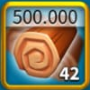

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
W
Found 42 items of W * 500,000
##########################


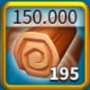

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
W
Found 195 items of W * 150,000
##########################


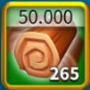

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
W
Found 265 items of W * 50,000
##########################


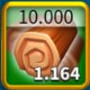

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
W
Found 1164 items of W * 10,000
##########################


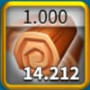

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
W
Found 14212 items of W * 1,000
##########################


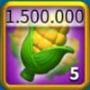

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
F
Found 5 items of F * 1,000
##########################


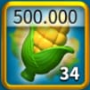

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
F
Found 34 items of F * 500,000
##########################


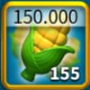

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
F
Found 155 items of F * 500,000
##########################


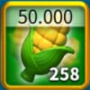

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
F
Found 258 items of F * 50,000
##########################


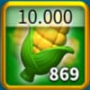

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
F
Found 869 items of F * 150,000
##########################


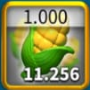

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
F
Found 11256 items of F * 1,000
##########################


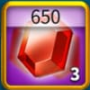

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
GEM
Found 3 items of GEM * 650
Food: 249,011,000
Wood: 89,352,000
Gem: 1,950


In [208]:
# Test
DEBUG = False
screenshot = cv2.imread(DRIVE_PATH+'inputs/aug4.jpeg')

total_by_type = get_total_item_from_screenshot(screenshot)
if ('S' in total_by_type):
  print(f'Stone: {total_by_type["S"]:,}')
if ('G' in total_by_type):
  print(f'Gold: {total_by_type["G"]:,}')
if ('F' in total_by_type):
  print(f'Food: {total_by_type["F"]:,}')
if ('W' in total_by_type):
  print(f'Wood: {total_by_type["W"]:,}')
if ('GEM' in total_by_type):
  print(f'Gem: {total_by_type["GEM"]:,}')


[9420.5, 9427.0, 9449.0, 9415.5, 9429.0, 9446.5, 9411.5, 9418.0, 9353.0, 9351.0, 9360.0, 9359.0]
Total areas: 12 - min: 7225 max: 15625 average: 9403.333333333334 median: 9416.75
##########################


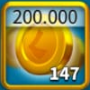

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
G
Found 147 items of G * 200,000
##########################


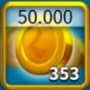

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
G
Found 353 items of G * 50,000
##########################


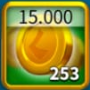

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
G
Found 253 items of G * 15,000
##########################


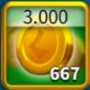

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
G
Found 667 items of G * 3,000
##########################


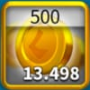

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
G
Found 13498 items of G * 500
##########################


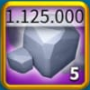

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
S
Found 5 items of S * 37,500
##########################


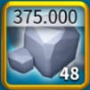

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
S
Found 48 items of S * 375,000
##########################


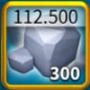

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
S
Found 300 items of S * 112,500
##########################


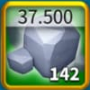

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
S
Found 142 items of S * 37,500
##########################


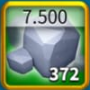

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
S
Found 372 items of S * 7,500
##########################


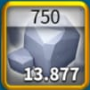

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
S
Found 13877 items of S * 750
##########################


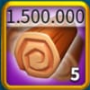

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
W
Found 5 items of W * 1,500,000
Stone: 70,460,250
Gold: 59,595,000
Wood: 7,500,000


In [215]:
# Test
DEBUG = False
screenshot = cv2.imread(DRIVE_PATH+'inputs/aug42.jpeg')

total_by_type = get_total_item_from_screenshot(screenshot)
if ('S' in total_by_type):
  print(f'Stone: {total_by_type["S"]:,}')
if ('G' in total_by_type):
  print(f'Gold: {total_by_type["G"]:,}')
if ('F' in total_by_type):
  print(f'Food: {total_by_type["F"]:,}')
if ('W' in total_by_type):
  print(f'Wood: {total_by_type["W"]:,}')
if ('GEM' in total_by_type):
  print(f'Gem: {total_by_type["GEM"]:,}')
